In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dataset_completo = pd.read_csv("https://cdn.buenosaires.gob.ar/datosabiertos/datasets/salud/casos-covid-19/casos_covid19.csv")

C:\Users\44594722\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (10,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
meses_replace = {"JAN":"01","FEB":"02","MAR":"03","APR":"04","MAY":"05","JUN":"06","JUL":"07","AUG":"08","SEP":"09","OCT":"10","NOV":"11","DEC":"12"}

In [32]:
dataset_completo["fecha_clasificacion"].str[5:9]

0         2020
1         2020
2         2020
3         2020
4         2020
          ... 
819082    2020
819083    2020
819084    2020
819085    2020
819086    2020
Name: fecha_clasificacion, Length: 819087, dtype: object

In [33]:
dataset_completo_procesado = dataset_completo.copy()
####################################### CREAMOS LA COLUMNA DEL DIA DE CLASIFICACION ########################################
año_clasificacion = dataset_completo_procesado["fecha_clasificacion"].str[5:9]
mes_clasificacion = dataset_completo_procesado["fecha_clasificacion"].str[2:5].replace(meses_replace)
dia_clasificacion = dataset_completo_procesado["fecha_clasificacion"].str[:2]
dataset_completo_procesado["mes/dia"] = año_clasificacion.map(str) + "/" + mes_clasificacion.map(str) +"/"+ dia_clasificacion.map(str)
#################################################################################################################

################################## CREAMOS LA COLUMNA DEL DIA DE LA MUERTE ##################################################
año_muerte = dataset_completo_procesado["fecha_fallecimiento"].str[5:9]
mes_muerte = dataset_completo_procesado["fecha_fallecimiento"].str[2:5].replace(meses_replace)
dia_muerte = dataset_completo_procesado["fecha_fallecimiento"].str[:2]
dataset_completo_procesado["mes/dia_fallecimiento"] = año_muerte.map(str) + "/" + mes_muerte.map(str) +"/"+ dia_muerte.map(str)
#############################################################################################################################

In [34]:
#################################### AQUI UTILIZAREMOS DISTINTOS CRITERIOS PARA SORTEAR EL DATASET ##########################
dataset_completo_procesado_sorted_clasificacion = dataset_completo_procesado.copy().sort_values("mes/dia")
dataset_completo_procesado_sorted_muerte = dataset_completo_procesado.copy().sort_values("mes/dia_fallecimiento")

In [35]:
def nuevos_casos_caba_dia(dia, residentes = True):
    filtro = dataset_completo_procesado.copy()
    if residentes:
        filtro = filtro[filtro["provincia"]=="CABA"]
    confirmados = filtro[filtro["clasificacion"]=="confirmado"]
    cant_casos = confirmados[confirmados["mes/dia"]==dia]
    return {dia: len(cant_casos)}

In [36]:
def nuevas_muertes_caba_dia(dia, residentes = True):
    filtro = dataset_completo_procesado.copy()
    if residentes:
        filtro = filtro[filtro["provincia"]=="CABA"]
    muertes = filtro[filtro["fallecido"]=="si"]
    cant_muertes = muertes[muertes["mes/dia_fallecimiento"]==dia]
    return {dia: len(cant_muertes)}

In [37]:
def nuevos_casos_caba_rango(desde="0",hasta="3000", residentes = True):
    filtro = dataset_completo_procesado_sorted_clasificacion.copy()
    if residentes:
        filtro = filtro[filtro["provincia"]=="CABA"]
    confirmados = filtro[filtro["clasificacion"]=="confirmado"]
    confirmados_dict = {}
    for i in confirmados["mes/dia"]:
        if desde <= i < hasta:
            confirmados_dict[i] = confirmados_dict.get(i,0) + 1 
    return confirmados_dict

In [38]:
def nuevas_muertes_caba_rango(desde="0",hasta="3000", residentes = True):
    filtro = dataset_completo_procesado_sorted_muerte.copy()
    if residentes:
        filtro = filtro[filtro["provincia"]=="CABA"]
    muertes = filtro[filtro["fallecido"]=="si"]
    muertes_dict = {}
    for i in muertes["mes/dia_fallecimiento"]:
        if desde <= i < hasta:
            muertes_dict[i] = muertes_dict.get(i,0) + 1 
    return muertes_dict

## Lo que viene a continuacion son pruebas

In [11]:
import datetime
import numpy as np
from sklearn.linear_model import LinearRegression

In [40]:
cases = nuevos_casos_caba_rango()
dates = list(cases.keys())
values = list(cases.values())

In [41]:
dates = [datetime.datetime.strptime(d,"%Y/%m/%d").date() for d in dates]


In [42]:
beta = 0.9
sample_size = int(1/(1-beta))
vt = 0
app = []
for i in range(len(values)):
    vt = beta*vt+(1-beta)*values[i]
    app.append(int(vt))

In [43]:
len(app)

269

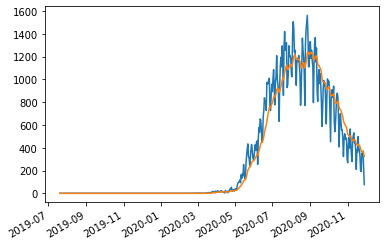

In [44]:
fig, ax = plt.subplots()
ax.plot(dates,values)
ax.plot(dates,app)
fig.autofmt_xdate()

In [51]:
linear_descent = app[app.index(max(app)):]

In [52]:
y = np.array(linear_descent).reshape(-1,1)

In [53]:
x = range(len(y))
x_train = np.array(x).reshape(-1,1)

In [54]:
reg = LinearRegression()

In [55]:
reg.fit(x_train,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

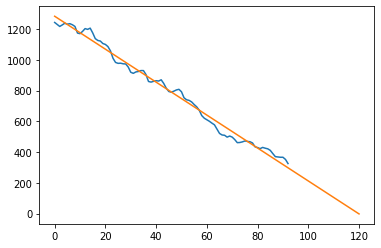

In [56]:
fig,ax = plt.subplots()
predictions = []
i = 0
pred = 1
while pred > 0:
    pred = reg.predict([[i]])[0]
    predictions.append(pred)
    i+=1
ax.plot(x,linear_descent)
ax.plot(range(len(predictions)),predictions)

In [57]:
len(predictions)

121

In [58]:
len(linear_descent)

93

In [59]:
print("Days until 0 cases:",str(len(predictions)-len(linear_descent)))

Days until 0 cases: 28
